In [7]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU



In [8]:
epochs = 1000
batch = 16
eta = 0.001
weight_decay = 6e-8
imageShape = (224, 224, 1)
maskShape = (224, 224, 1)

In [9]:

def read_images(path):
    images = []
    for filename in sorted(os.listdir(path)):
        img = cv2.imread(os.path.join(path, filename), 0)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0   # normalize only
        images.append(img)
    return np.array(images)


In [10]:
def read_masks(path):
    masks = []
    for filename in sorted(os.listdir(path)):
        mask = cv2.imread(os.path.join(path, filename), 0)
        mask = cv2.resize(mask, (224, 224))
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)  # binarize ONLY masks
        masks.append(mask)
    return np.array(masks)

In [11]:
BASE_DATASET = Path(
    r"c:\project\dentalmlproject\Notebook\Adult-tooth-segmentation-dataset"
)

images_dir = BASE_DATASET / "Panoramic-radiography-database" / "images"
mask_dir = BASE_DATASET / "Panoramic-radiography-database" / "mask"
images = read_images(images_dir)
masks = read_masks(mask_dir)

In [12]:
print(len(masks))

598


C:\Users\Nada\AppData\Local\Temp\ipykernel_19844\2770776013.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


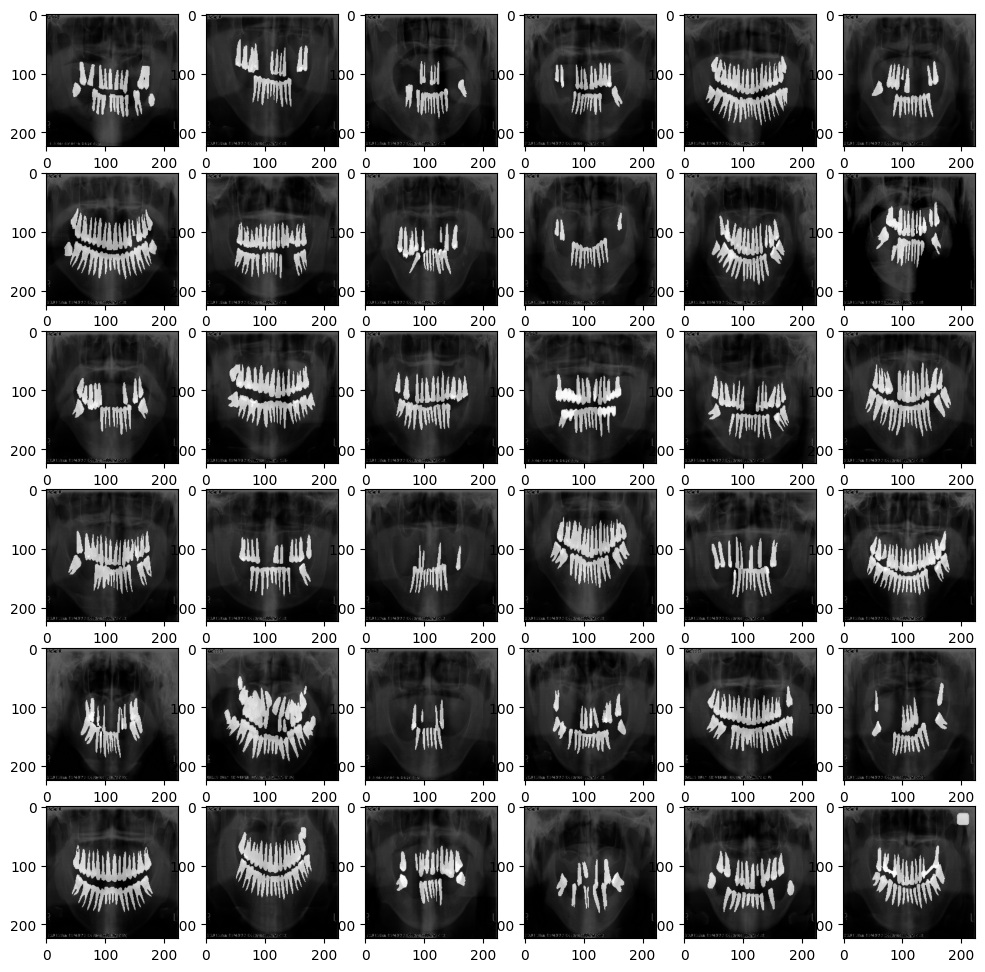

In [13]:
plt.figure(figsize = (12, 12))
for i in range(36):
    plt.subplot(6, 6, (i + 1))
    plt.imshow(images[i], cmap = 'gray')
    plt.imshow(masks[i], alpha = 0.6, cmap = 'gray')
plt.legend()

In [14]:
np.unique(masks), np.min(masks), np.max(masks), np.min(images), np.max(masks)

(array([0., 1.], dtype=float32),
 np.float32(0.0),
 np.float32(1.0),
 np.float64(0.0),
 np.float32(1.0))

In [15]:
x = tf.keras.layers.Input(shape = (224, 224, 1))
y = tf.keras.layers.Input(shape = (224, 224, 1))
z = tf.keras.layers.multiply([x, y])
m = tf.keras.models.Model(inputs = [x, y], outputs = z)
m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer[0][0… │
│                     │ 1)                │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
imagesByMasks = m([images[:64], masks[:64]])
imagesByMasks.shape

TensorShape([64, 224, 224, 1])

C:\Users\Nada\AppData\Local\Temp\ipykernel_19844\3578247554.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


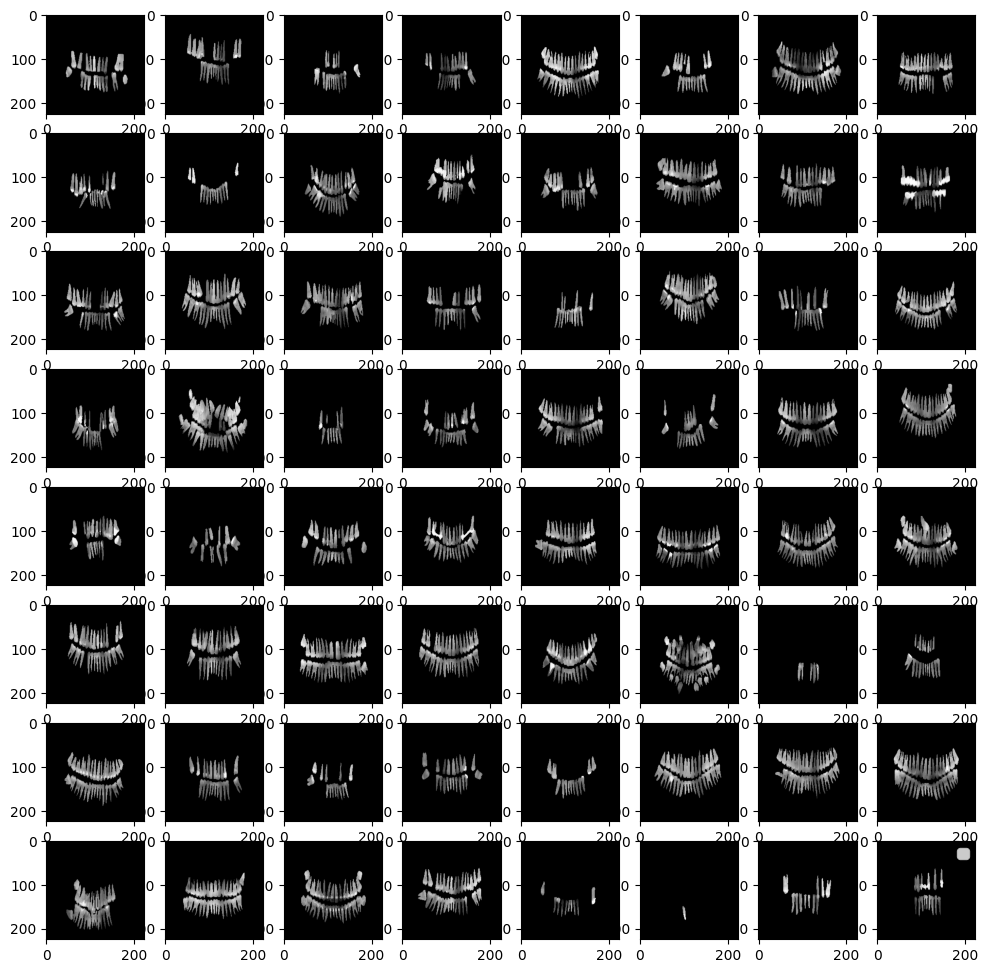

In [17]:
plt.figure(figsize = (12, 12))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesByMasks[i], cmap = 'gray')
plt.legend()

In [18]:
i = 80
validImages = images[:i]
validMasks = masks[:i]
trainImages = images[i:]
trainMasks = masks[i:]
validImages.shape, validMasks.shape, trainImages.shape, trainMasks.shape

((80, 224, 224), (80, 224, 224), (518, 224, 224), (518, 224, 224))

In [19]:
def convolution(inputs, filter, padding, strides, kernel, activation, conv_type):
  x = inputs
  x = tf.keras.layers.Conv2D(filter, kernel_size = kernel, padding = padding,
                    strides = strides)(x)
  x = tf.keras.layers.GroupNormalization(groups = filter)(x)
  if conv_type == 'decoder':
      x = tf.keras.layers.Activation(activation)(x)
      x = tf.keras.layers.Conv2D(filter*2, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = tf.keras.layers.GroupNormalization(groups = filter*2)(x)
      x = tf.keras.layers.Activation(activation)(x)
      x = tf.keras.layers.Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = tf.keras.layers.GroupNormalization(groups = filter)(x)
  x = tf.keras.layers.average([x, tf.keras.layers.Conv2D(filter, kernel_size = 1, padding = 'same',
                                      strides = 1)(inputs)])
  x = tf.keras.layers.Activation(activation)(x)
  return x

In [20]:
def encoder(input, filter, padding, strides, kernel, activation):
  x = input
  x = convolution(x, filter, padding, strides, kernel, activation, 'encoder')
  downsample = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
  return downsample, x

In [21]:
def decoder(input, filter, skip, padding, strides, kernel, activation):
  x = input
  x = tf.keras.layers.Conv2DTranspose(filter, kernel_size = kernel, padding = padding,
                             strides = 2, activation = activation)(x)
  x = tf.keras.layers.average([x, skip])
  x = convolution(x, filter, padding, strides, kernel, activation, 'decoder')
  return x

In [22]:
def UNet(input_shape=(224, 224, 1), base_filters=32):

    # 1️⃣ Input layer
    inputs = tf.keras.layers.Input(shape=input_shape)

    # 2️⃣ Encoder (DOWN path)
    e1, s1 = encoder(inputs, base_filters, 'same', 1, 3, 'relu')
    e2, s2 = encoder(e1, base_filters*2, 'same', 1, 3, 'relu')
    e3, s3 = encoder(e2, base_filters*4, 'same', 1, 3, 'relu')
    e4, s4 = encoder(e3, base_filters*8, 'same', 1, 3, 'relu')

    # 3️⃣ Bottleneck
    b = convolution(e4, base_filters*16, 'same', 1, 3, 'relu', 'encoder')

    # 4️⃣ Decoder (UP path)
    d1 = decoder(b, base_filters*8, s4, 'same', 1, 3, 'relu')
    d2 = decoder(d1, base_filters*4, s3, 'same', 1, 3, 'relu')
    d3 = decoder(d2, base_filters*2, s2, 'same', 1, 3, 'relu')
    d4 = decoder(d3, base_filters, s1, 'same', 1, 3, 'relu')

    # 5️⃣ Output
    outputs = tf.keras.layers.Conv2D(
        1, kernel_size=1, activation='sigmoid'
    )(d4)

    # 6️⃣ Model
    model = tf.keras.models.Model(inputs, outputs, name="UNet")
    return model

In [23]:
model = UNet()
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 224, 224,  │         64 │ conv2d[0][0]      │
│ (GroupNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │         64 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 224, 224,  │          0 │ group_normalizat… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ average[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 112, 112,  │          0 │ activation[0][0]  │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_2[0][0]    │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      2,112 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_1 (Average) │ (None, 112, 112,  │          0 │ group_normalizat… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ average_1[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 56, 56,    │          0 │ activation_1[0][… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ average_pooling2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]    │
│ (GroupNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │      8,320 │ average_pooling2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_2 (Average) │ (None, 56, 56,    │          0 │ group_normalizat

 Total params: 7,322,401 (27.93 MB)

 Trainable params: 7,322,401 (27.93 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
images = images[..., np.newaxis]
masks  = masks[..., np.newaxis]

print(images.shape, masks.shape)


(598, 224, 224, 1) (598, 224, 224, 1)


In [25]:
split = int(0.8 * len(images))

train_images = images[:split]
train_masks  = masks[:split]

val_images = images[split:]
val_masks  = masks[split:]


In [26]:
model = UNet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    trainImages,
    trainMasks,
    validation_data=(validImages, validMasks),
    epochs=7,
    batch_size=2
)

Epoch 1/7
259/259 ━━━━━━━━━━━━━━━━━━━━ 130s 467ms/step - accuracy: 0.9446 - loss: 0.1499 - val_accuracy: 0.9673 - val_loss: 0.0823
Epoch 2/7
259/259 ━━━━━━━━━━━━━━━━━━━━ 123s 475ms/step - accuracy: 0.9706 - loss: 0.0738 - val_accuracy: 0.9757 - val_loss: 0.0614
Epoch 3/7
259/259 ━━━━━━━━━━━━━━━━━━━━ 122s 472ms/step - accuracy: 0.9781 - loss: 0.0552 - val_accuracy: 0.9824 - val_loss: 0.0440
Epoch 4/7
259/259 ━━━━━━━━━━━━━━━━━━━━ 123s 473ms/step - accuracy: 0.9815 - loss: 0.0464 - val_accuracy: 0.9836 - val_loss: 0.0410
Epoch 5/7
259/259 ━━━━━━━━━━━━━━━━━━━━ 117s 450ms/step - accuracy: 0.9839 - loss: 0.0398 - val_accuracy: 0.9855 - val_loss: 0.0365
Epoch 6/7
259/259 ━━━━━━━━━━━━━━━━━━━━ 125s 482ms/step - accuracy: 0.9850 - loss: 0.0368 - val_accuracy: 0.9863 - val_loss: 0.0340
Epoch 7/7
259/259 ━━━━━━━━━━━━━━━━━━━━ 125s 482ms/step - accuracy: 0.9858 - loss: 0.0347 - val_accuracy: 0.9871 - val_loss: 0.0323


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


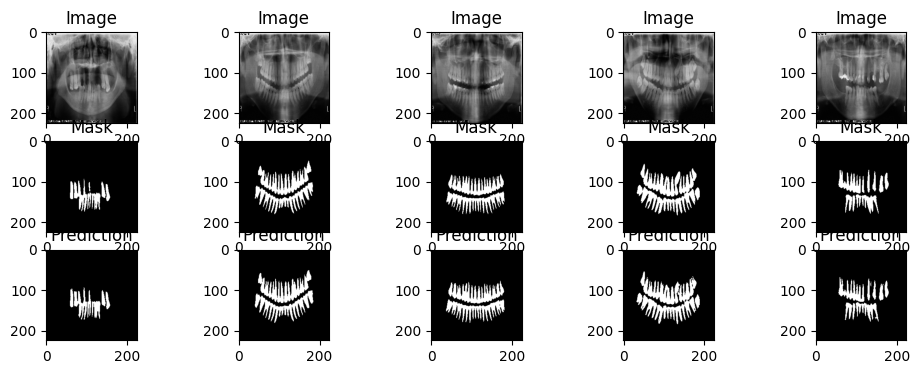

In [28]:
preds = model.predict(val_images[:5])

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(val_images[i].squeeze(), cmap='gray')
    plt.title("Image")

    plt.subplot(3, 5, i+6)
    plt.imshow(val_masks[i].squeeze(), cmap='gray')
    plt.title("Mask")

    plt.subplot(3, 5, i+11)
    plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
    plt.title("Prediction")
plt.show()

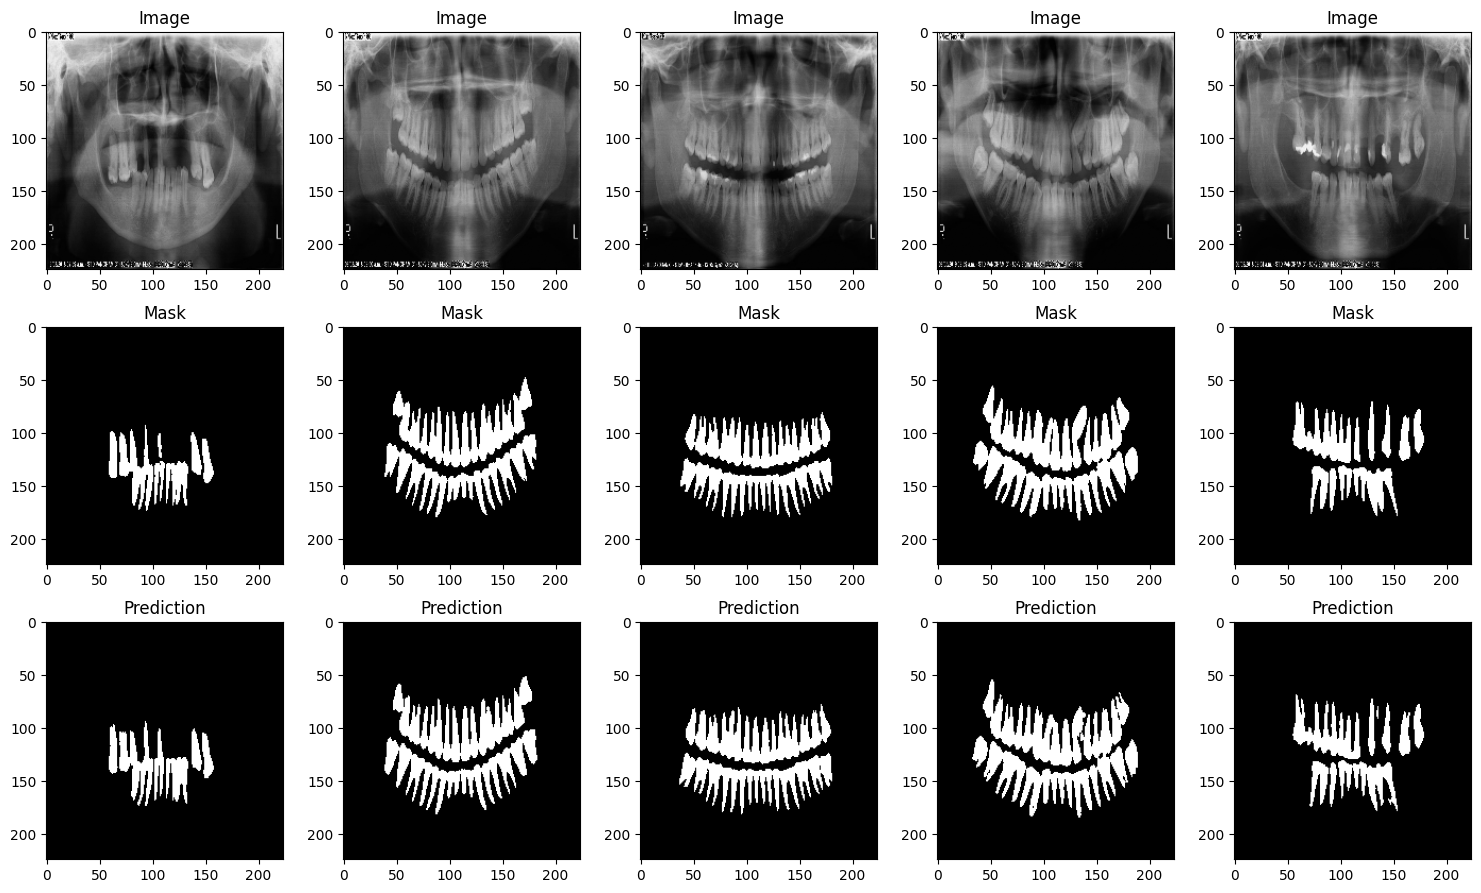

In [44]:
plt.figure(figsize=(15, 9))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(val_images[i].squeeze(), cmap='gray')
    plt.title("Image")

    plt.subplot(3, 5, i+6)
    plt.imshow(val_masks[i].squeeze(), cmap='gray')
    plt.title("Mask")

    plt.subplot(3, 5, i+11)
    plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
    plt.title("Prediction")
plt.tight_layout()
plt.show()

In [36]:
imgpath = BASE_DATASET / "panorama.jpg"
img = cv2.imread(imgpath , 0)


In [37]:
input_size = (224, 224)  # your model input
img_resized = cv2.resize(img, input_size)

In [38]:
img_norm = img_resized / 255.0

In [39]:
img_input = np.expand_dims(img_norm, axis=-1)  # add channel -> (224,224,1)
img_input = np.expand_dims(img_input, axis=0)  # add batch -> (1,224,224,1)

In [40]:
pred_mask = model.predict(img_input)  # output shape: (1,224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


In [41]:
# Remove batch and channel dimension
pred_mask = pred_mask[0, :, :, 0]

# Binarize mask (threshold 0.5)
binary_mask = (pred_mask > 0.5).astype(np.uint8)

In [42]:
binary_mask_full = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))

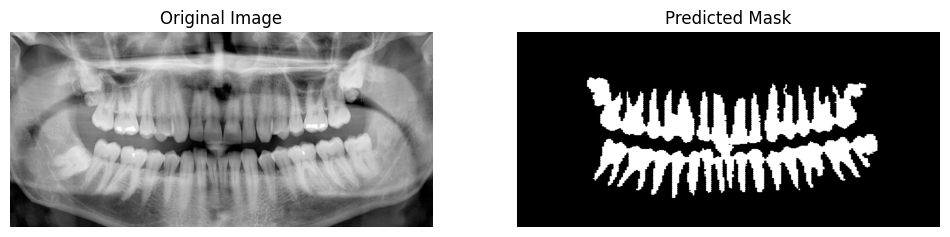

In [43]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Predicted Mask")
plt.imshow(binary_mask_full, cmap='gray')
plt.axis('off')

plt.show()